<a href="https://colab.research.google.com/github/theKirill/GensimSample/blob/master/Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификатор интентов
Каждый класс описывает небольшое количество вариантов/запросов *(погода - подскажите погоду)*. Классифицикация запросов по классам реализуется с помощью [gensim](https://radimrehurek.com/gensim/) и [keras](https://keras.io/).


**Используется:**
*   Python 3
*   gensim
*   keras
*   sklearn
*   pandas
*   numpy
*   nltk with English stopwords & RegexpTokenizer

**Набор данных (dataset):**
*   https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-enginesist


In [0]:
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
import keras_metrics
import seaborn as sn
from sklearn.metrics import classification_report

In [37]:
!pip install keras_metrics

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Exploring the data

In [0]:
file_csv = pd.read_csv('drive/My Drive/ForGensim/train.csv')

In [0]:
file_csv = file_csv.dropna()
file_csv['text'].apply(lambda x: len(x.split(' '))).sum()

105347

Набор данных составляет всего 105к слов.

In [4]:
file_csv[:5]

,text,intents
0,Add another song to the Cita RomГЎntica playli...,AddToPlaylist
1,add clem burke in my playlist Pre-Party R&B Jams,AddToPlaylist
2,Add Live from Aragon Ballroom to Trapeo,AddToPlaylist
3,add Unite and Win to my night out,AddToPlaylist
4,Add track to my Digster Future Hits,AddToPlaylist


In [0]:
all_texts = file_csv['text']
all_intents = file_csv['intents']

In [0]:
unique_intents = file_csv.intents.unique()

In [7]:
unique_intents

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
       'SearchScreeningEvent'], dtype=object)

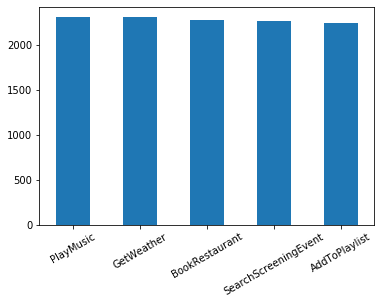

In [171]:
file_csv.intents.value_counts().plot(kind="bar", rot = 30)

In [170]:
file_csv.intents.value_counts()

PlayMusic               2300
GetWeather              2300
BookRestaurant          2273
SearchScreeningEvent    2259
AddToPlaylist           2242
Name: intents, dtype: int64

Данные достаточно сбалансированные – у каждого класса почти одинаковое количество запросов.

# Подготовка данных
Удаление стоп-слов и пунктуации

In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[a-zA-Z]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("english"))
  without_stop_words = [w for w in words if w not in stop_words and len(w) > 1]
  return without_stop_words

In [0]:
sentences = np.array(all_texts.apply(lambda x : tokenize(x)))

In [24]:
sentences[:5]

array([list(['add', 'another', 'song', 'cita', 'rom', 'ntica', 'playlist']),
       list(['add', 'clem', 'burke', 'playlist', 'pre', 'party', 'jams']),
       list(['add', 'live', 'aragon', 'ballroom', 'trapeo']),
       list(['add', 'unite', 'win', 'night']),
       list(['add', 'track', 'digster', 'future', 'hits'])], dtype=object)

# Работа с Word2Vec

In [0]:
VECTOR_SIZE = 200
WINDOW_SIZE = 10
MIN_COUNT = 3
ITER_COUNT = 10
WORKERS = 4

In [0]:
# Обучение модели Word2Vec
word2vec_model = Word2Vec(sentences, size = VECTOR_SIZE, window = WINDOW_SIZE, min_count = MIN_COUNT, workers = WORKERS, iter = ITER_COUNT)

Получение ближайших слов к «song»:

In [27]:
word2vec_model.most_similar('song', topn = 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('track', 0.9990552663803101),
 ('album', 0.9990246891975403),
 ('artist', 0.9973072409629822)]

Сохранение модели для дальнейшего использования – дообучения:

In [28]:
word2vec_model.save('drive/My Drive/ForGensim/Word2VecModel')
word2vec_model.wv.save_word2vec_format('drive/My Drive/ForGensim/Word2VecModel.txt', binary=False)
word2vec_model.wv.save_word2vec_format('drive/My Drive/ForGensim/Word2VecModel.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Работа с keras

In [0]:
# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(intents_for_each, unique_intents, build_binary_matrix = True):
  intents_to_digit = []

  for intent in intents_for_each:
    intents_to_digit.append(unique_intents.index(intent))

  if build_binary_matrix:
    intents_to_digit = to_categorical(intents_to_digit, len(unique_intents))
  
  return intents_to_digit

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, unique_intents):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(unique_intents[prediction[i]])

  return answers

In [0]:
# Создание модели
def get_model(word2vec_model, COUNT_CLASSES):
    model = Sequential() 
    model.add(word2vec_model.wv.get_keras_embedding(train_embeddings = True))
    
    model.add(Dropout(0.2))

    model.add(Conv1D(50,
                 3,
                 padding = 'valid',
                 activation = 'relu',
                 strides = 1))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(250))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(COUNT_CLASSES, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  
    return model

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Преобразование всех текстов в числовые последовательности, заменяя слова на числа по словарю.
text = tokenizer.texts_to_sequences(sentences)
text = pad_sequences(text, maxlen = 10)

Разбивка и преобразования данных для обучения модели, получение модели:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(text, all_intents, test_size = 0.2)

In [0]:
y_train = transform_to_categorical(y_train, unique_intents.tolist())

In [0]:
COUNT_CLASSES = unique_intents.shape[0]

In [109]:
keras_model = get_model(word2vec_model, COUNT_CLASSES)
keras_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         551600    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 50)          30050     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_12 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_6 (Activation)    (None, 250)              

Обучение керас модели:

In [0]:
BATCH = 32
EPOCHS_COUNT = 10

In [110]:
keras_model.fit(X_train, y_train, batch_size = BATCH, epochs = EPOCHS_COUNT, validation_split = 0.2,
             callbacks = [ModelCheckpoint('drive/My Drive/ForGensim/keras_model.h5', save_best_only = True)])

Train on 7279 samples, validate on 1820 samples
Epoch 1/10
7279/7279 [==============================] - 2s 300us/step - loss: 0.5357 - acc: 0.8009 - val_loss: 0.1197 - val_acc: 0.9758
Epoch 2/10
7279/7279 [==============================] - 2s 219us/step - loss: 0.0706 - acc: 0.9834 - val_loss: 0.0684 - val_acc: 0.9841
Epoch 3/10
7279/7279 [==============================] - 2s 218us/step - loss: 0.0320 - acc: 0.9922 - val_loss: 0.0554 - val_acc: 0.9907
Epoch 4/10
7279/7279 [==============================] - 2s 221us/step - loss: 0.0169 - acc: 0.9956 - val_loss: 0.0546 - val_acc: 0.9890
Epoch 5/10
7279/7279 [==============================] - 2s 219us/step - loss: 0.0124 - acc: 0.9968 - val_loss: 0.0497 - val_acc: 0.9879
Epoch 6/10
7279/7279 [==============================] - 2s 225us/step - loss: 0.0066 - acc: 0.9982 - val_loss: 0.0600 - val_acc: 0.9879
Epoch 7/10
7279/7279 [==============================] - 2s 217us/step - loss: 0.0100 - acc: 0.9978 - val_loss: 0.0585 - val_acc: 0.9885


Предсказания для тестовой выборки (её мы получили выше):

In [0]:
prediction = keras_model.predict_classes(X_test)

In [112]:
answers = transform_from_categorical(prediction, unique_intents.tolist())
answers[:5]

['GetWeather',
 'AddToPlaylist',
 'BookRestaurant',
 'SearchScreeningEvent',
 'BookRestaurant']

Делаем отчёт по предсказанию (по разным метрикам) + строим матрицу ошибок:

In [0]:
y_test = transform_to_categorical(y_test, unique_intents.tolist(), False)

In [114]:
print(classification_report(y_test, prediction, target_names = unique_intents))

                      precision    recall  f1-score   support

       AddToPlaylist       1.00      0.96      0.98       438
      BookRestaurant       0.99      1.00      0.99       492
          GetWeather       0.99      0.99      0.99       482
           PlayMusic       0.97      1.00      0.98       435
SearchScreeningEvent       0.99      0.99      0.99       428

            accuracy                           0.99      2275
           macro avg       0.99      0.99      0.99      2275
        weighted avg       0.99      0.99      0.99      2275



Как видно, наша модель определяет интенты с точностью ~ 99%

In [0]:
# Преобразование номеров классов в названия классов
prediction_ = transform_from_categorical(prediction, unique_intents.tolist())
y_test_ = transform_from_categorical(np.array(y_test), unique_intents.tolist())

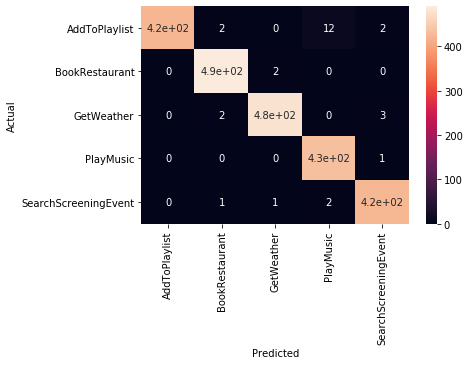

In [116]:
data = {'prediction': prediction_,
        'actual':    y_test_
        }

df = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])

sn.heatmap(confusion_matrix, annot = True)

Как видно, наша модель хуже всего научилась распознавать интент `SearchScreeningEvent` (путает с другими классами), также путает между собой интенты `AddToPlaylist` и `PlayMusic`

# Дообучение модели

Подготовка данных:

In [0]:
# Объединение двух списков
def add_new_data(old, new):
  result = old

  for i in new:
    result.append(i)

  return result

In [0]:
new_file_csv = pd.read_csv('drive/My Drive/ForGensim/train_new.csv')

In [0]:
all_new_texts = new_file_csv['text']
all_new_intents = new_file_csv['intents']

In [0]:
unique_new_intents = new_file_csv.intents.unique()

In [83]:
unique_new_intents

array(['RateBook', 'SearchCreativeWork'], dtype=object)

In [0]:
all_unique_intents = add_new_data(unique_intents.tolist(), unique_new_intents.tolist())

In [85]:
all_unique_intents

['AddToPlaylist',
 'BookRestaurant',
 'GetWeather',
 'PlayMusic',
 'SearchScreeningEvent',
 'RateBook',
 'SearchCreativeWork']

In [0]:
COUNT_CLASSES = len(all_unique_intents)

In [0]:
sentences_new = np.array(all_new_texts.apply(lambda x : tokenize(x)))

In [0]:
old_and_new_sentences = add_new_data(sentences.tolist(), sentences_new)

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(old_and_new_sentences)

# Преобразование всех текстов в числовые последовательности, заменяя слова на числа по словарю.
text = tokenizer.texts_to_sequences(old_and_new_sentences)
text = pad_sequences(text, maxlen = 10)

In [0]:
all_intents = add_new_data(all_intents.tolist(), all_new_intents)

Получение и дообучение модели word2vec:

In [117]:
# Получение старой модели Word2Vec
word2vec_model = Word2Vec.load("drive/My Drive/ForGensim/Word2VecModel")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [128]:
# Дообучение модели word2vec
word2vec_model.build_vocab(sentences_new, update = True)
word2vec_model.train(sentences_new, total_examples = len(sentences_new), epochs = word2vec_model.epochs)

(92709, 210890)

In [185]:
word2vec_model.save('drive/My Drive/ForGensim/Word2VecModel')
word2vec_model.wv.save_word2vec_format('drive/My Drive/ForGensim/Word2VecModel.txt', binary=False)
word2vec_model.wv.save_word2vec_format('drive/My Drive/ForGensim/Word2VecModel.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Получение и дообучение модели keras:

In [0]:
keras_model = load_model('drive/My Drive/ForGensim/keras_model.h5')

In [0]:
#запоминаем все слои
layers = []
for i in range(len(all_unique_intents)):
  layers.append(keras_model.layers.pop())
  keras_model.pop()

keras_model.pop()

In [0]:
#меняем первый слой с новой обученной модель word2vec
keras_model = Sequential()
keras_model.add(word2vec_model.wv.get_keras_embedding(train_embeddings = True))

In [0]:
#добавляем оставшиеся слои из старой модели, кроме последнего
new_layers_count = len(layers) - 1
for i in range(new_layers_count):
  keras_model.add(layers[new_layers_count - i])

In [0]:
#добавляем последний слой для нового кол-ва классов
keras_model.add(Dense(COUNT_CLASSES, activation = 'softmax'))

In [0]:
keras_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [125]:
keras_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         551600    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 50)          30050     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_12 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_6 (Activation)    (None, 250)              

In [0]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(text, all_intents, test_size = 0.2)

In [0]:
y_train_new = transform_to_categorical(y_train_new, all_unique_intents)

In [157]:
keras_model.fit(X_train_new, y_train_new, batch_size = BATCH, epochs = EPOCHS_COUNT, validation_split = 0.2)

Train on 10165 samples, validate on 2542 samples
Epoch 1/10
10165/10165 [==============================] - 2s 219us/step - loss: 0.0323 - acc: 0.9917 - val_loss: 0.0342 - val_acc: 0.9890
Epoch 2/10
10165/10165 [==============================] - 2s 224us/step - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0267 - val_acc: 0.9921
Epoch 3/10
10165/10165 [==============================] - 2s 225us/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0279 - val_acc: 0.9929
Epoch 4/10
10165/10165 [==============================] - 2s 221us/step - loss: 0.0087 - acc: 0.9973 - val_loss: 0.0320 - val_acc: 0.9925
Epoch 5/10
10165/10165 [==============================] - 2s 218us/step - loss: 0.0076 - acc: 0.9973 - val_loss: 0.0303 - val_acc: 0.9913
Epoch 6/10
10165/10165 [==============================] - 2s 214us/step - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0337 - val_acc: 0.9929
Epoch 7/10
10165/10165 [==============================] - 2s 215us/step - loss: 0.0078 - acc: 0.9976 - val_loss: 0.0445 - v

In [0]:
prediction = keras_model.predict_classes(X_test_new)

Делаем отчёт по предсказанию (по разным метрикам) + строим матрицу ошибок:

In [0]:
y_test_new = transform_to_categorical(y_test_new, all_unique_intents, False)

In [160]:
print(classification_report(y_test_new, prediction, target_names = all_unique_intents))

                      precision    recall  f1-score   support

       AddToPlaylist       1.00      0.99      0.99       448
      BookRestaurant       0.99      1.00      0.99       440
          GetWeather       1.00      1.00      1.00       480
           PlayMusic       0.98      0.99      0.99       445
SearchScreeningEvent       0.98      1.00      0.99       429
            RateBook       1.00      0.99      0.99       467
  SearchCreativeWork       0.99      0.97      0.98       468

            accuracy                           0.99      3177
           macro avg       0.99      0.99      0.99      3177
        weighted avg       0.99      0.99      0.99      3177



Точность ~ 98%

In [0]:
# Преобразование номеров классов в названия классов
prediction_ = transform_from_categorical(prediction, all_unique_intents)
y_test_new_ = transform_from_categorical(np.array(y_test_new), all_unique_intents)

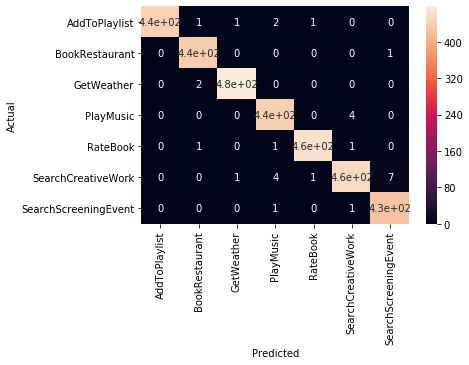

In [162]:
data = {'prediction': prediction_,
        'actual':    y_test_new_
        }

df = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])

sn.heatmap(confusion_matrix, annot = True)

Наша модель чаще всего путает интенты `PlayMusic` с `SearchCreativeWork`, `SearchCreativeWork` с `SearchScreeningEvent`